# Import libraries

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to /Users/abdul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [62]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

# Import data

In [49]:
#Using polar to read the data since it is faster than pandas for large data
data=pd.read_csv('/Users/abdul/Desktop/machine learning/data/home-data-for-ml-course/NLP/Reviews.csv')
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# Quick EDA

In [10]:
print(data.shape)
# reduction size of data
df=data.head(5000)
df=df[['Id','Score','Summary','Text']]

(568454, 10)


In [11]:
df.head(4)

,Id,Score,Summary,Text
0,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,2,Cough Medicine,If you are looking for the secret ingredient i...


In [12]:
# checking for missing values
df.isnull().sum()

Id         0
Score      0
Summary    0
Text       0
dtype: int64

In [63]:
df['Text'][0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

Text(0.5, 0, 'Stars rating')

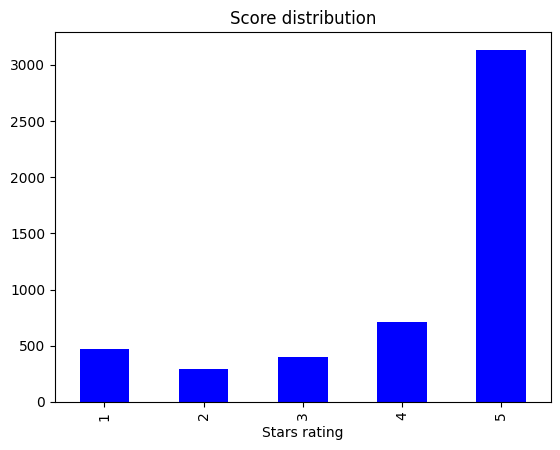

In [13]:
ax=df['Score'].value_counts().sort_index().plot(kind='bar',color='blue',title='Score distribution')
ax.set_xlabel('Stars rating')

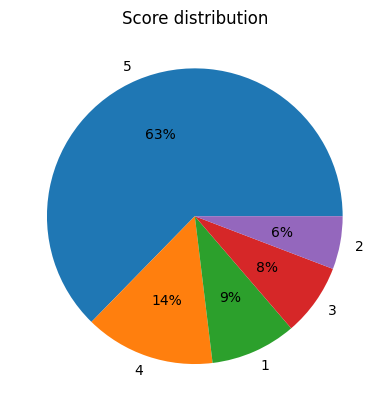

In [36]:
ax=plt.pie(df['Score'].value_counts(), labels=df['Score'].value_counts().index, autopct='%.0f%%') 
ax=plt.title('Score distribution') 
# displaying chart 
plt.show() 

In [39]:
df['Score'].value_counts()

Score
5    3134
4     712
1     469
3     395
2     290
Name: count, dtype: int64

We see that the score it is not uniform, we have more good grade than bad. We can assume in the dataset we will have more good sentiments.

In [17]:
# let's create a new column containing the length of the text
df['Text_length']=df['Text'].apply(len)
df.head(3)

,Id,Score,Summary,Text,Text_length
0,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,263
1,2,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,190
2,3,4,"""Delight"" says it all",This is a confection that has been around a fe...,509


In [18]:
df.dtypes

Id              int64
Score           int64
Summary        object
Text           object
Text_length     int64
dtype: object

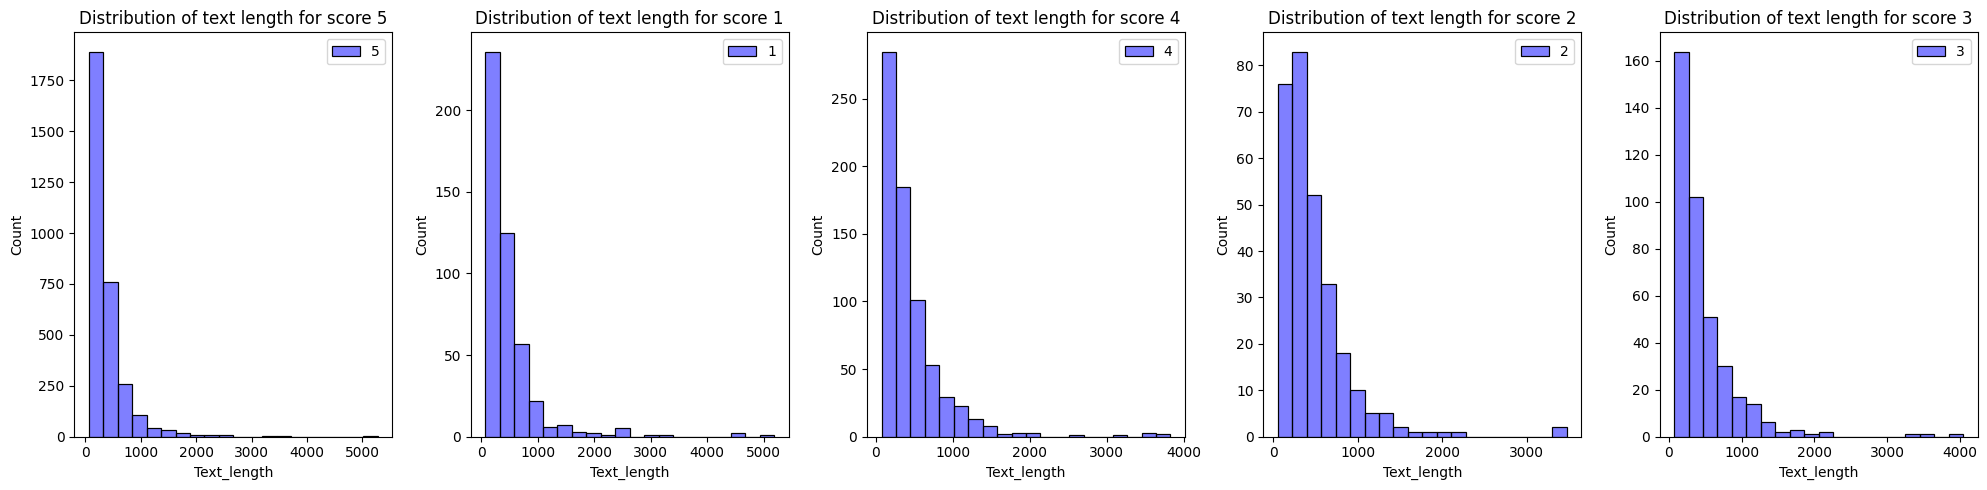

In [58]:
# Distribution of text length by score
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

for i, score in enumerate(df['Score'].unique()):
    sns.histplot(df[df['Score']==score]['Text_length'], bins=20, color='blue', label=score, alpha=0.5, ax=ax[i])
    ax[i].set_title(f'Distribution of text length for score {score}')
    ax[i].legend()

plt.tight_layout()
plt.show()

Score 4,2,3 seems share the same distribution.
Score 5 and 1 seems share the same distribution.

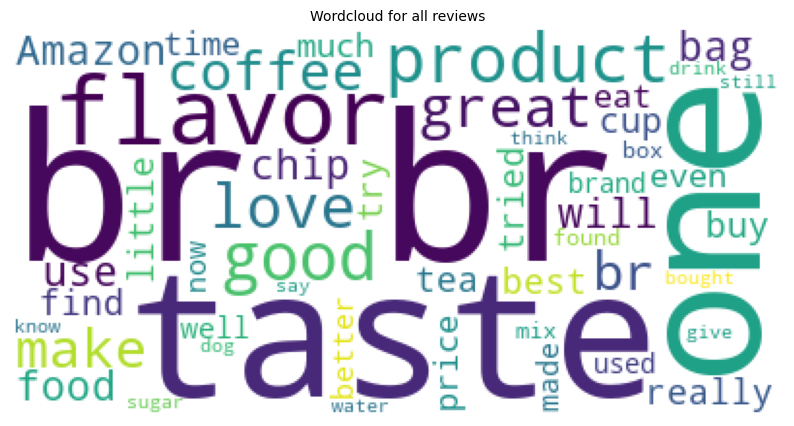

In [59]:
# Visualizing the distribution of text length with wordcloud with all data
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df.Text)
# Combine all reviews
reviews = " ".join([review for review in df['Text']])
                      
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)
# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

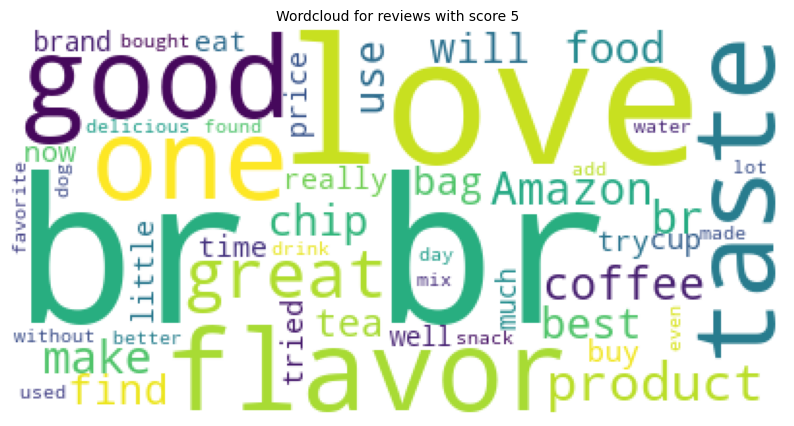

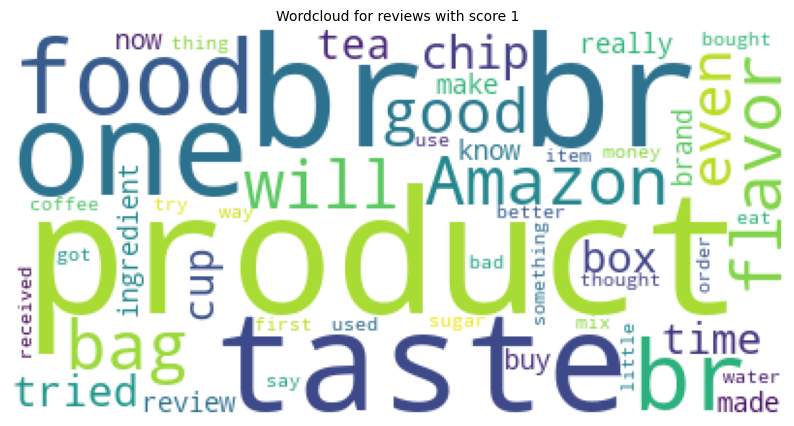

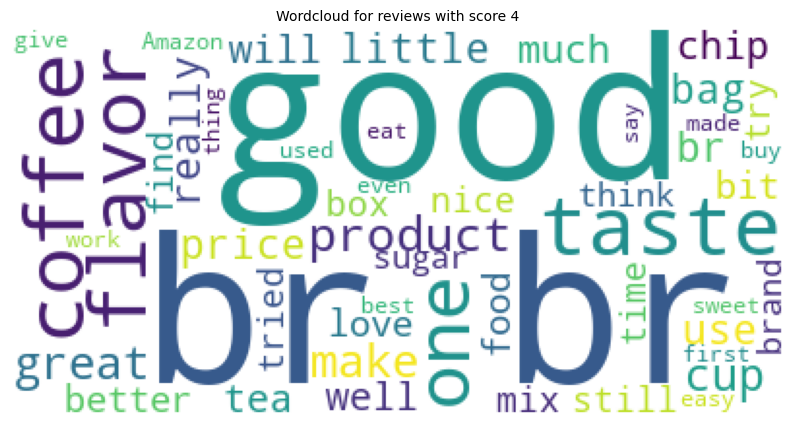

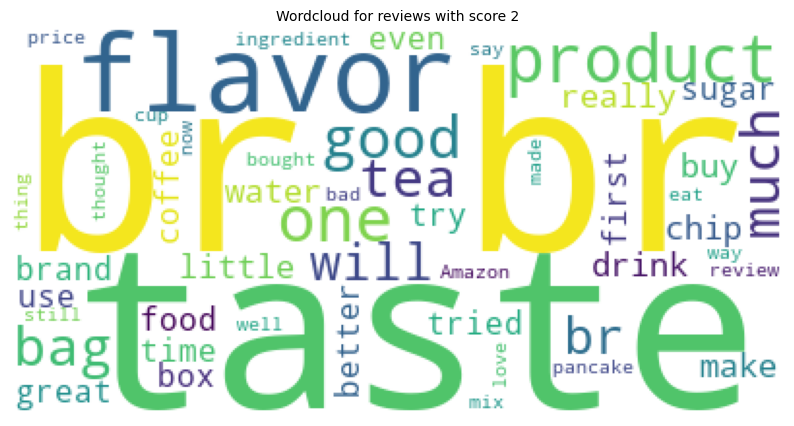

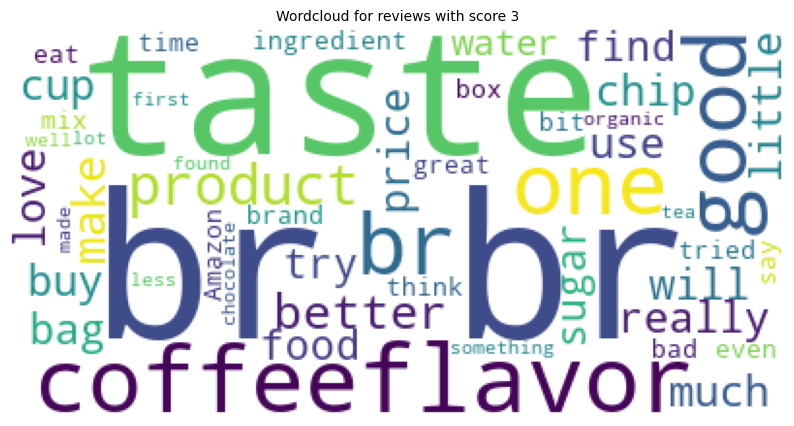

In [60]:
# Vizualizing the distribution of text length with wordcloud for each score
cv = CountVectorizer(stop_words='english')
for score in df['Score'].unique():
    # Combine all reviews
    reviews = " ".join([review for review in df[df['Score']==score]['Text']])
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', max_words=50)
    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(reviews))
    plt.title(f'Wordcloud for reviews with score {score}', fontsize=10)
    plt.axis('off')
    plt.show()

# Pre-processing and modelling